In [1]:
import pandas as pd
import numpy as np 
import os 

import plotly.express as px
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose


import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 


import seaborn as sns 
import matplotlib.pyplot as plt 
import glob 


# Contenus 
Les données sont telechargées depuis ENTSOE Transparency Platform et representent respectivement la charge electrique suisse et la production par source 
- Lecture et nettoyage des données brutes
- Points d'attentions sur le traitement du temps
- Analyse exploratoire
- Decomposition en Trend/Saisonnalité/Residus

### Data Import


In [2]:
load_files = glob.glob( '../data/load/*.csv')

load_in = pd.concat((pd.read_csv(file) for file in load_files), ignore_index=True)

print(load_in.shape)
load_in.head()

(52614, 3)


Time (CET/CEST)  \
0  01.01.2019 00:00 - 01.01.2019 01:00   
1  01.01.2019 01:00 - 01.01.2019 02:00   
2  01.01.2019 02:00 - 01.01.2019 03:00   
3  01.01.2019 03:00 - 01.01.2019 04:00   
4  01.01.2019 04:00 - 01.01.2019 05:00   

  Day-ahead Total Load Forecast [MW] - BZN|CH Actual Total Load [MW] - BZN|CH  
0                                      8600.0                          7037.0  
1                                      7732.0                          7096.0  
2                                      7563.0                          7244.0  
3                                      7379.0                          7443.0  
4                                      6996.0                          7353.0

In [3]:
load_in.tail()

Time (CET/CEST)  \
52609  31.12.2024 19:00 - 31.12.2024 20:00   
52610  31.12.2024 20:00 - 31.12.2024 21:00   
52611  31.12.2024 21:00 - 31.12.2024 22:00   
52612  31.12.2024 22:00 - 31.12.2024 23:00   
52613  31.12.2024 23:00 - 01.01.2025 00:00   

      Day-ahead Total Load Forecast [MW] - BZN|CH  \
52609                                           -   
52610                                           -   
52611                                           -   
52612                                           -   
52613                                           -   

      Actual Total Load [MW] - BZN|CH  
52609                               -  
52610                               -  
52611                               -  
52612                               -  
52613                               -

In [4]:
load_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52614 entries, 0 to 52613
Data columns (total 3 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Time (CET/CEST)                              52614 non-null  object
 1   Day-ahead Total Load Forecast [MW] - BZN|CH  52608 non-null  object
 2   Actual Total Load [MW] - BZN|CH              52607 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [5]:
load_work = load_in.copy(deep = True)
## Change column names 
load_work.columns = ['time','load_forecast','load']
## Parse correctly the timestamp 

def parse_ts( df, column_name ):

    ## Parses the timestamp from this format  e.g., '01.01.2019 00:00 - 01.01.2019 01:00'

    df[['start','end']] = df[column_name].str.split('-' , expand = True )
    df['dt'] = pd.to_datetime( df['start'], dayfirst=True, errors = 'coerce')

    df.drop( columns = ['start','end',column_name ], inplace = True)


    return df


## Parsing timestamps 
print( load_work.shape )
load_work_parsed = parse_ts( load_work , 'time')
print( load_work_parsed.shape) 

## Parsing numeric 

load_work_parsed['load'] = pd.to_numeric( load_work_parsed['load'] , errors = 'coerce' ) 
load_work_parsed['load_forecast'] = pd.to_numeric( load_work_parsed['load_forecast'] , errors = 'coerce' )


(52614, 3)
(52614, 3)


In [6]:
load_work_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52614 entries, 0 to 52613
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   load_forecast  50711 non-null  float64       
 1   load           50681 non-null  float64       
 2   dt             52614 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [7]:
## Attention to the null values !! 
load_work_parsed.isnull().sum()

load_forecast    1903
load             1933
dt                  0
dtype: int64

Text(0.5, 1.0, 'Null Values for Load')

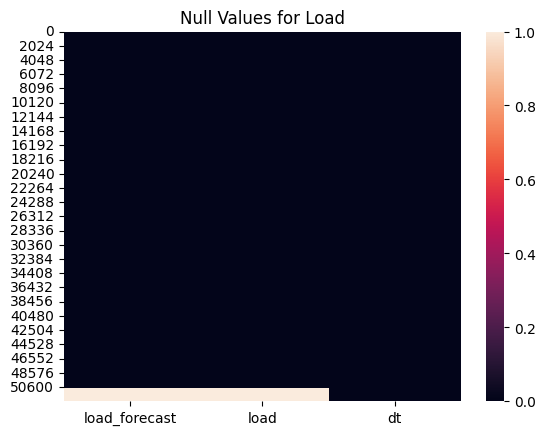

In [8]:
# Voir les nulls
sns.heatmap( load_work_parsed.isnull()  )
plt.title( 'Null Values for Load')

In [9]:
## Strategie: utiliser un mois complet jusqu'en octobre 
load_clean = load_work_parsed[load_work_parsed.dt < '2024-10-01 00:00:00']

load_clean.tail()

load_forecast    load                  dt
50400         7486.0  6736.0 2024-09-30 19:00:00
50401         7566.0  6876.0 2024-09-30 20:00:00
50402         7312.0  6549.0 2024-09-30 21:00:00
50403         6998.0  6672.0 2024-09-30 22:00:00
50404         6150.0  6287.0 2024-09-30 23:00:00

In [10]:
## Traitement du temps 

## Attention au referentiel de temps : CET 
## Controle des doublons
## Controle des valeurs manquants 

load_clean.groupby( 'dt' ).count().sort_values( by = 'load' , ascending = False).head(20)

load_forecast  load
dt                                      
2022-10-30 02:00:00              2     2
2020-10-25 02:00:00              2     2
2023-10-29 02:00:00              2     2
2019-10-27 02:00:00              2     2
2021-10-31 02:00:00              2     2
2019-01-01 00:00:00              1     1
2022-10-31 18:00:00              1     1
2022-10-31 19:00:00              1     1
2022-10-31 20:00:00              1     1
2022-10-31 21:00:00              1     1
2022-10-31 22:00:00              1     1
2022-10-31 23:00:00              1     1
2022-11-01 00:00:00              1     1
2022-11-01 01:00:00              1     1
2022-11-01 02:00:00              1     1
2022-10-31 16:00:00              1     1
2022-11-01 03:00:00              1     1
2022-11-01 04:00:00              1     1
2022-11-01 05:00:00              1     1
2022-11-01 06:00:00              1     1

In [11]:
## Attention doit etre mise ! 

load_df = load_clean.copy( deep = True)
print( load_df.shape ) 
load_df.drop_duplicates( subset = 'dt',  inplace = True , keep = 'first')
print( load_df.shape ) 

(50405, 3)
(50400, 3)


In [12]:
load_df[load_df.load.isnull()==True]

load_forecast  load                  dt
2138             NaN   NaN 2019-03-31 02:00:00
10875            NaN   NaN 2020-03-29 02:00:00
19612            NaN   NaN 2021-03-28 02:00:00
28349            NaN   NaN 2022-03-27 02:00:00
35969         9065.0   NaN 2023-02-07 13:00:00
37086            NaN   NaN 2023-03-26 02:00:00
45991            NaN   NaN 2024-03-31 02:00:00

In [13]:
# Examiner un cas particulier 

load_df[load_df.dt>'2023-03-26 00:00:00'].head(10)

load_forecast    load                  dt
37085         6555.0  6530.0 2023-03-26 01:00:00
37086            NaN     NaN 2023-03-26 02:00:00
37087         5759.0  6257.0 2023-03-26 03:00:00
37088         6421.0  6023.0 2023-03-26 04:00:00
37089         6736.0  6711.0 2023-03-26 05:00:00
37090         6763.0  6838.0 2023-03-26 06:00:00
37091         6781.0  6838.0 2023-03-26 07:00:00
37092         6402.0  6919.0 2023-03-26 08:00:00
37093         6733.0  7293.0 2023-03-26 09:00:00
37094         6847.0  6761.0 2023-03-26 10:00:00

In [ ]:
# Controler les nombre de timestamps 
load_df.groupby( load_df.dt.dt.year).count()

In [14]:
## Simplement ignorer les valeurs nulles
# Il faudrait etre tres attentifs dans des cas de production à l'impact de tout cela
#  
load_df = load_df.dropna()

In [15]:
load_df.groupby( load_df.dt.dt.year).count()

load_forecast  load    dt
dt                             
2019           8759  8759  8759
2020           8783  8783  8783
2021           8759  8759  8759
2022           8759  8759  8759
2023           8758  8758  8758
2024           6575  6575  6575

In [16]:
load_df[load_df.dt>'2023-03-26 00:00:00'].head(10)

load_forecast    load                  dt
37085         6555.0  6530.0 2023-03-26 01:00:00
37087         5759.0  6257.0 2023-03-26 03:00:00
37088         6421.0  6023.0 2023-03-26 04:00:00
37089         6736.0  6711.0 2023-03-26 05:00:00
37090         6763.0  6838.0 2023-03-26 06:00:00
37091         6781.0  6838.0 2023-03-26 07:00:00
37092         6402.0  6919.0 2023-03-26 08:00:00
37093         6733.0  7293.0 2023-03-26 09:00:00
37094         6847.0  6761.0 2023-03-26 10:00:00
37095         6894.0  6908.0 2023-03-26 11:00:00

In [17]:
load_df.isnull().sum()

load_forecast    0
load             0
dt               0
dtype: int64

In [18]:
## Persist for later use 
load_df.to_csv( '..\\data\\curated_data\\load_clean.csv', index = False )

## Attention 
Jamais sousestimer cette partie car elle peut donner pas mal de problemes si elle n'est pas faite correctement ! 

Connaitre la matiere premiere est primordiale pour effectuer des bonnes analyses 

Ressources d'interet
- https://fr.wikipedia.org/wiki/Temps_universel_coordonn%C3%A9 
- https://fr.wikipedia.org/wiki/Heure_normale_d%27Europe_centrale 
- https://www.forecastclub.blog/2024/02/how-to-handle-time-series-missing-data.html 

## Data Quality and exploration 

In [19]:
px.line( data_frame = load_df , x = 'dt' , y = 'load' , title = 'Demande electrique en Suisse [MW]')

In [ ]:
#sns.lineplot( data = load_df[:8000] , x = 'dt' , y = 'load' )

In [21]:
import pandas as pd
import plotly.express as px

def plot_timeseries_with_granularity(df_in, ts_column, column, granularity, hue=None):
    """
    Plot a Plotly line plot with granularity on the x-axis and the average of a column on the y-axis.
    
    Parameters:
    - df: DataFrame containing the data.
    - ts_column: The column containing the timestamp or datetime.
    - column: The column for which to calculate the average on the y-axis.
    - granularity: The granularity for the x-axis (e.g., 'week', 'dayofweek', 'month', 'hour').
    - hue: Optional; a column to differentiate lines in the plot (e.g., 'year', 'quarter').
    """
    # Ensure ts_column is a datetime object

    df = df_in.copy( deep = True )
    df[ts_column] = pd.to_datetime(df[ts_column])

    # Extract the desired granularity
    if granularity == 'week':
        df['granularity'] = df[ts_column].dt.isocalendar().week
    elif granularity == 'dayofweek':
        df['granularity'] = df[ts_column].dt.dayofweek
    elif granularity == 'month':
        df['granularity'] = df[ts_column].dt.month
    elif granularity == 'hour':
        df['granularity'] = df[ts_column].dt.hour
    else:
        raise ValueError("Invalid granularity. Choose from 'week', 'dayofweek', 'month', 'hour'.")

    # Optionally add 'year', 'quarter', or other hue options if provided
    if hue == 'year':
        df['hue'] = df[ts_column].dt.year
    elif hue == 'quarter':
        df['hue'] = df[ts_column].dt.quarter

    # Group by granularity and hue (if provided) and calculate the mean of the column
    if hue:
        grouped = df.groupby(['granularity', 'hue'])[column].mean().reset_index()
    else:
        grouped = df.groupby(['granularity'])[column].mean().reset_index()

    # Plot the graph using Plotly
    if hue:
        fig = px.line(grouped, x='granularity', y=column, color='hue',
                      labels={'granularity': granularity.capitalize(), column: f'Average {column}', 'hue': hue.capitalize()},
                      title=f'Average {column} by {granularity}')
    else:
        fig = px.line(grouped, x='granularity', y=column,
                      labels={'granularity': granularity.capitalize(), column: f'Average {column}'},
                      title=f'Average {column} by {granularity}')

    # Show the interactive plot
    fig.show()



## EDA Analysis  


In [26]:
sns.set_palette('tab10')
plot_timeseries_with_granularity( load_df, ts_column = 'dt', column = 'load' , granularity= 'month' , hue = 'year')

In [23]:
sns.set_palette('tab10')
## Attention au dataset, combien de semaines en 2024?
 
plot_timeseries_with_granularity( load_df, 
                                  ts_column = 'dt', 
                                  column = 'load' ,
                                  granularity= 'dayofweek' , 
                                  hue = 'year')

In [25]:
sns.set_palette('tab10')
plot_timeseries_with_granularity( load_df, 
                                  ts_column = 'dt', 
                                  column = 'load' , 
                                  granularity= 'hour' , 
                                  hue = 'year')

## Trend, Seasonality, Residual

In [29]:
def simple_seasonal_decompose(df, ts_column, column, model='additive', freq=None):
    """
    Decomposes a time series into trend, seasonal, and residual components, and plots them using Matplotlib.
    
    Parameters:
    - df: DataFrame containing the data.
    - ts_column: The column containing the timestamp or datetime.
    - column: The column containing the time series values.
    - model: The type of decomposition ('additive' or 'multiplicative').
    - freq: Frequency of the time series (if not set, inferred automatically).
    """
    # Ensure ts_column is a datetime object and set it as the index
    df[ts_column] = pd.to_datetime(df[ts_column])
    df = df.set_index(ts_column)

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df[column], model=model, period=freq, extrapolate_trend=True)

    # Plot the decomposition components (observed, trend, seasonal, residual)
    decomposition.plot()
    plt.show()

    return decomposition 

In [30]:
monthly_load_df = load_df.set_index( 'dt' ).resample('MS').sum().reset_index()
monthly_load_df

dt  load_forecast       load
0  2019-01-01      6310043.0  6229097.0
1  2019-02-01      5515960.0  5413703.0
2  2019-03-01      5639884.0  5668715.0
3  2019-04-01      4880462.0  5047127.0
4  2019-05-01      4963737.0  5157062.0
..        ...            ...        ...
64 2024-05-01      4828466.0  4744645.0
65 2024-06-01      4562142.0  4666850.0
66 2024-07-01      4826136.0  4461961.0
67 2024-08-01      4872230.0  4215314.0
68 2024-09-01      4937687.0  4385986.0

[69 rows x 3 columns]

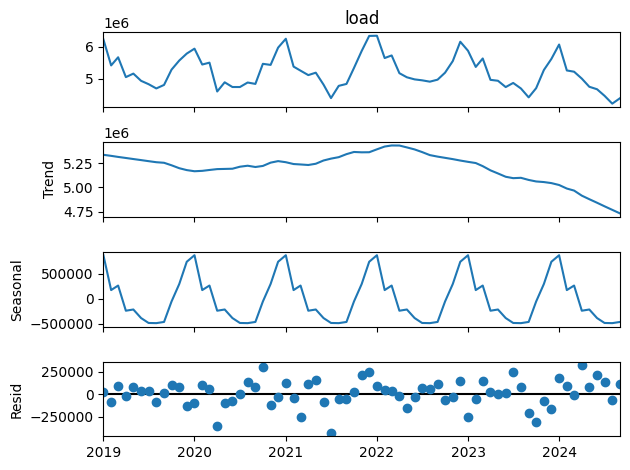

In [31]:
decomposed  = simple_seasonal_decompose( monthly_load_df , ts_column= 'dt', column = 'load')

<Axes: >

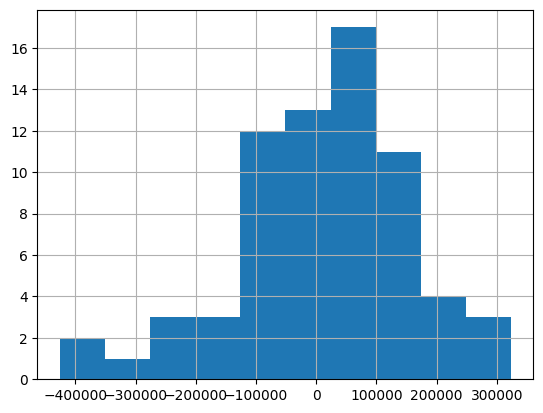

In [35]:
# La comprehension des residues peut aider à voir si la decomposition simple ne capture pas l'entierté du comportement, ou des effets 
#decomposed.resid.plot()
decomposed.resid.hist()

In [38]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

plot_acf_pacf(monthly_load_df)


NameError: name 'plot_acf_pacf' is not defined

In [ ]:
## Time series differentes peuvent avoir comportement differents !  

### Generation 
L'analyse des time serie temporelle peut donner des resultats differents selon la nature du phenomene observé

In [36]:
## Preparation deja faite auparavant
prd_in = pd.read_csv('..\\data\\curated_data\\generation_clean.csv')
prd_in['dt'] = pd.to_datetime( prd_in['dt'])
 
prd_df  = prd_in[['dt','solar','wind_onshore']]


In [37]:
f = go.Figure()
for j in ['solar','wind_onshore']:
    f.add_trace( go.Scatter( x = prd_df.dt , y = prd_df[j], name = j ))

f.update_layout( title= 'Solar & Wind Generation [MW]')
f.show()

In [ ]:
prd_df[10:15]

In [ ]:
plot_timeseries_with_granularity(prd_df , 'dt' , 'solar', 'month','year')

In [ ]:
plot_timeseries_with_granularity(prd_df , 'dt' , 'solar', 'week','year')

In [ ]:
monthly_solar_df = prd_df[['dt','solar']].set_index('dt').resample('MS').sum().reset_index()
monthly_solar_df = monthly_solar_df[monthly_solar_df.dt.dt.year >= 2020]

decomposed  = simple_seasonal_decompose( monthly_solar_df,
                                         ts_column= 'dt', 
                                         column = 'solar' ,
                                         model = 'multiplicative',
                                         freq = 12)

In [ ]:
monthly_solar_df.head()

In [ ]:
## Another Decomposition technique improves the shape of the decomposition. 

from statsmodels.tsa.seasonal import STL
stl = STL(monthly_solar_df.set_index('dt'), seasonal=13)  # Seasonal smoothing of 13 months (close to yearly cycle)
result = stl.fit()

# Plotting the components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original series
ax1.plot(result.observed)
ax1.set_ylabel('Observed')
ax1.set_title('STL Decomposition of Solar Generation Time Series')

# Trend component
ax2.plot(result.trend)
ax2.set_ylabel('Trend')

# Seasonal component
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')

# Residuals
ax4.plot(result.resid)
ax4.set_ylabel('Residuals')
ax4.set
